# FastPitch and Mixer-TTS Training

This notebook is designed to provide a guide on how to train FastPitch and Mixer-TTS as part of the TTS pipeline. It contains the following sections:
  1. **Introduction**: FastPitch and Mixer-TTS in NeMo
  2. **Preprocessing**: how to prepare data for FastPitch and Mixer-TTS 
  3. **Training**: example of FastPitch training and Mixer-TTS training

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [2]:
import time
## Update & Upgrade
# !apt-get update -y
# !apt-get upgrade -y

## Install dependencies
# !apt-get install -y build-essential python3-dev sox libsndfile1 ffmpeg
# !pip install wget text-unidecode matplotlib>=3.3.2 -y
# !pip install mamba-ssm
!pip install gdown noisereduce wandb
!apt install tree -y
!pip install google-api-python-client google-auth google-auth-oauthlib google-auth-httplib2 watchdog

## Clone NeMo repo
NEMO_DIR = 'nemo'
!git clone https://github.com/NVIDIA/NeMo.git $NEMO_DIR
!git clone https://github.com/nipponjo/tts-arabic-pytorch.git

start = time.time()
## Install NeMo
BRANCH = 'main'
!python -m pip install "git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]"
# !pip install "git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]" -v

end = time.time()
print(f"Installation took {(end - start):.2f} seconds.")

# exit() # Optional for restarting the kernel

In [1]:
import json
import gdown
import nemo
import torch
import librosa
import numpy as np
import re
import subprocess
import os
import sys
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from googleapiclient.discovery import build
from google.oauth2 import service_account
from datetime import datetime
from pathlib import Path
from tqdm.notebook import tqdm
from nemo.collections.tts.models.base import SpectrogramGenerator
from nemo.collections.tts.models import FastPitchModel, MixerTTSModel, HifiGanModel
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import librosa.display
import IPython.display as ipd
from sklearn.metrics import mean_squared_error

import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

%matplotlib inline

2025-06-10 00:36:14.431497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749515774.628187     425 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749515774.685402     425 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# NAWAR
SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-mixer-tts-nawar.json'
PARENT_FOLDER_ID = "1BJXlJ5Ek4HWGxntZdx38SuZYRHSKu5k5"
# train_sub_data = "/kaggle/working/train_sup_data"
# PITCH_MEAN=129.74388122558594
# PITCH_STD=19.90825653076172
# PITCH_MIN=65.4063949584961
# PITCH_MAX=1719.801513671875
# # pitch_fmin=65.4063949584961 
# # pitch_fmax=2057.0478515625 
# # pitch_mean=132.2518768310547 
# # pitch_std=24.731098175048828 

# MBZUAI
# SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-mbzuai.json'
# PARENT_FOLDER_ID = "1BXXPLxSV_sj6V4wuc2vnPvzTI5yjLbJW"
# train_sub_data = "/kaggle/working/mbzuai_train_sup_data"
PITCH_MIN=65.4063949584961 
PITCH_MAX=1303.3658447265625 
PITCH_MEAN=112.00650787353516 
PITCH_STD=22.997333526611328

In [4]:
# Authentication and upload to drive
SCOPES = ['https://www.googleapis.com/auth/drive']
# SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-mixer-tts-nawar.json'
# PARENT_FOLDER_ID = "1BJXlJ5Ek4HWGxntZdx38SuZYRHSKu5k5"

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    return creds

def upload_file(file_path):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    file_name = os.path.basename(file_path)
    file_metadata = {
        'name': file_name,
        'parents': [PARENT_FOLDER_ID]
    }
    
    try:
        # Perform the upload
        uploaded_file = service.files().create(
            body=file_metadata,
            media_body=file_path
        ).execute()
        print(f"File '{file_name}' uploaded successfully with ID: {uploaded_file.get('id')}")
        return True  # Upload success
    except Exception as e:
        print(f"Failed to upload file '{file_name}': {e}")
        return False  # Upload failed

def list_files():
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    results = service.files().list(pageSize=100, fields="files(id, name)").execute()
    files = results.get('files', [])
    if not files:
        print("No files found.")
    else:
        print("Files:")
        for file in files:
            print(f"{file['name']} (ID: {file['id']})")

def delete_file(file_id):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    try:
        service.files().delete(fileId=file_id).execute()
        print(f"Deleted file with ID: {file_id}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Introduction

### Mixer-TTS

Mixer-TTS is another non-autoregressive model for mel-spectrogram generation. It is structurally similar to FastPitch: duration prediction, pitch prediction, unsupervised TTS alignment framework, but the main difference is that Mixer-TTS is based on the [MLP-Mixer](https://arxiv.org/abs/2105.01601) architecture adapted for speech synthesis.

FastPitch and Mixer-TTS like most NeMo models are defined as a LightningModule, allowing for easy training via PyTorch Lightning, and parameterized by a configuration, currently defined via a yaml file and loading using Hydra.

Let's take a look using NeMo's pretrained models and how to use it to generate spectrograms.

In [ ]:
# Let's see what pretrained models are available for FastPitch and Mixer-TTS
print("FastPitch pretrained models:")
print(FastPitchModel.list_available_models())
print("=====================================")
print("Mixer-TTS pretrained models:")
print(MixerTTSModel.list_available_models())

# Loading the Dataset


In [ ]:
# Replace 'FILE_ID' with your actual file ID from Google Drive
file_id = '1oWoqhTDgwuYyUJEiTTFzQ7hiIDiaul6P' 
gdown.download(f"https://drive.google.com/uc?id={file_id}", 'nawar_audio_data.zip', quiet=False)

In [ ]:
!unzip -q nawar_audio_data.zip -d nawar_dataset

In [ ]:
!mv /kaggle/working/nawar_dataset/content/audio_data/audio_preprocessed_train/* /kaggle/working/nawar_dataset
!mv /kaggle/working/nawar_dataset/content/audio_data/audio_preprocessed_val/* /kaggle/working/nawar_dataset
!rm -rf nawar_dataset/content

In [ ]:
!find /kaggle/working/nawar_dataset -type f -name "*.flac" | wc -l


In [ ]:
!wget https://raw.githubusercontent.com/nawarhalabi/Arabic-Phonetiser/master/utterance-pronunciations.txt


In [ ]:
import json

input_txt_path = "/kaggle/working/utterance-pronunciations.txt"
output_jsonl_path = "utterance-pronunciations.json"

with open(input_txt_path, "r", encoding="utf-8") as fin, open(output_jsonl_path, "w", encoding="utf-8") as fout:
    for line in fin:
        line = line.strip()
        if not line:
            continue
        # Safely split using quote pattern
        if line.startswith('"') and line.count('"') >= 4:
            parts = line.split('" "')
            if len(parts) == 2:
                filename = parts[0].strip('"')
                transcription = parts[1].strip('"')
                entry = {
                    "audio_filepath": filename,
                    "text": transcription
                }
                fout.write(json.dumps(entry, ensure_ascii=False) + "\n")


In [ ]:
import json
import random

# Paths
input_jsonl_path = "utterance-pronunciations.json"
train_output_path = "train.json"
val_output_path = "val.json"

# Load all lines
with open(input_jsonl_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Shuffle the data for random splitting
random.seed(42)
random.shuffle(data)

# Split ratio (e.g., 80% train, 20% val)
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train_data = data[:split_index]
val_data = data[split_index:]

# Write train.json
with open(train_output_path, "w", encoding="utf-8") as f:
    for item in train_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

# Write val.json
with open(val_output_path, "w", encoding="utf-8") as f:
    for item in val_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"✅ Done! Train: {len(train_data)} samples | Val: {len(val_data)} samples")

In [ ]:
import json
import soundfile as sf  # Make sure to install via: pip install soundfile

def modify_json_file(file_path, output_path, old_path, new_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line.strip())
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")

    for entry in data:
        # Build new audio path
        new_audio_path = new_path + entry['audio_filepath'].replace(".wav", ".flac")
        # new_audio_path = new_path + entry['audio_filepath']
        entry['audio_filepath'] = new_audio_path

        # Compute duration using soundfile
        
        try:
            audio_info = sf.info(new_audio_path)
            entry['duration'] = round(audio_info.frames / audio_info.samplerate, 3)  # in seconds, rounded to 3 decimals
        except RuntimeError as e:
            print(f"Error reading audio file {new_audio_path}: {e}")
            entry['duration'] = None  # or you can skip this entry

    with open(output_path, 'w', encoding='utf-8') as f:
        for item in data:
            json.dump(item, f, ensure_ascii=False)
            f.write('\n')

    print(f"✅ File paths and durations updated successfully for {output_path}!")


In [ ]:
# Define paths for training and validation datasets
train_file_path   = '/kaggle/working/train.json'   # Path for training dataset
val_file_path     = '/kaggle/working/val.json'     # Path for validation dataset
train_output_path = '/kaggle/working/train_data.json'                           # Output path for modified training dataset
val_output_path   = '/kaggle/working/val_data.json'                           # Output path for modified validation dataset
old_audio_path    = '/content/audio_data/audio_preprocessed_'                   # Current path in the JSON 
new_audio_path_train  = '/kaggle/working/nawar_dataset/'    # New path to replace with

# Modify JSON for training and validation
modify_json_file(train_file_path, train_output_path, old_audio_path + "train", new_audio_path_train)
modify_json_file(val_file_path, val_output_path, old_audio_path + "val", new_audio_path_train)

In [ ]:
data_prev = []
with open(train_file_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data_prev.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data_prev[2]

In [ ]:
data = []
with open(train_output_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[2]

In [ ]:


def remove_silence_energy_threshold(
    audio_path,
    output_path,
    frame_length=2048,
    hop_length=512,
    energy_threshold_ratio=0.1
):
    y, sr = librosa.load(audio_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    threshold = energy_threshold_ratio * np.max(rms)
    non_silent_frames = np.where(rms > threshold)[0]

    if len(non_silent_frames) == 0:
        print(f"No non-silent frames found for {audio_path}")
        return

    intervals = librosa.frames_to_samples(non_silent_frames, hop_length=hop_length)
    cleaned_audio = []

    for i in intervals:
        start = i
        end = min(i + hop_length, len(y))
        cleaned_audio.extend(y[start:end])

    cleaned_audio = np.array(cleaned_audio)
    sf.write(output_path, cleaned_audio, sr, format='FLAC')

def process_folder(input_folder, output_folder, energy_threshold_ratio=0.1):
    os.makedirs(output_folder, exist_ok=True)
    flac_files = [f for f in os.listdir(input_folder) if f.endswith('.flac')]

    for flac_file in tqdm(flac_files, desc="Processing audio files"):
        input_path = os.path.join(input_folder, flac_file)
        output_path = os.path.join(output_folder, flac_file)
        remove_silence_energy_threshold(
            audio_path=input_path,
            output_path=output_path,
            energy_threshold_ratio=energy_threshold_ratio
        )

# Example usage
# process_folder(
#     input_folder='/kaggle/working/nawar_dataset',
#     output_folder='/kaggle/working/nawar_cleaned_dataset',
#     energy_threshold_ratio=0.1
# )


In [ ]:
# Define paths for training and validation datasets
train_file_path   = '/kaggle/working/train.json'   # Path for training dataset
val_file_path     = '/kaggle/working/val.json'     # Path for validation dataset
train_output_path = '/kaggle/working/train_data.json'                           # Output path for modified training dataset
val_output_path   = '/kaggle/working/val_data.json'                           # Output path for modified validation dataset
old_audio_path    = '/content/audio_data/audio_preprocessed_'                   # Current path in the JSON 
new_audio_path_train  = '/kaggle/working/nawar_cleaned_dataset/'    # New path to replace with

# Modify JSON for training and validation
modify_json_file(train_file_path, train_output_path, old_audio_path + "train", new_audio_path_train)
modify_json_file(val_file_path, val_output_path, old_audio_path + "val", new_audio_path_train)

In [ ]:
data_prev = []
with open(train_file_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data_prev.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data_prev[2]

In [ ]:
data = []
with open(train_output_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[2]

## MBZUAI Data

In [5]:
!gdown 1yUXGteld79-gDq2MCnk6gWcPHwyYzq1z
!gdown 1rG2CN68fZY94usUBTV7z35Ir1Biw8EYd

Downloading...
From (original): https://drive.google.com/uc?id=1yUXGteld79-gDq2MCnk6gWcPHwyYzq1z
From (redirected): https://drive.google.com/uc?id=1yUXGteld79-gDq2MCnk6gWcPHwyYzq1z&confirm=t&uuid=e3bdcfa4-5b0c-47ea-a24a-9ad9a8d45ae3
To: /kaggle/working/MBZUAI_ClArTTS_data_preprocessed.zip
100%|█████████████████████████████████████████| 905M/905M [00:08<00:00, 107MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rG2CN68fZY94usUBTV7z35Ir1Biw8EYd
From (redirected): https://drive.google.com/uc?id=1rG2CN68fZY94usUBTV7z35Ir1Biw8EYd&confirm=t&uuid=80036034-f7aa-4d06-818a-1b5f77f35a43
To: /kaggle/working/MBZUAI_ClArTTS_cleaned.zip
100%|█████████████████████████████████████████| 819M/819M [00:08<00:00, 101MB/s]


In [ ]:
!unzip /kaggle/working/MBZUAI_ClArTTS_cleaned.zip
!unzip -j /kaggle/working/MBZUAI_ClArTTS_data_preprocessed.zip content/MBZUAI_ClArTTS_data_preprocessed/train_data_preprocessed.json content/MBZUAI_ClArTTS_data_preprocessed/val_data_preprocessed.json
# !unzip /kaggle/working/MBZUAI_ClArTTS_data_preprocessed.zip
# !mv /kaggle/working/content/MBZUAI_ClArTTS_data_preprocessed /kaggle/working/MBZUAI_ClArTTS_data_preprocessed
!mv /kaggle/working/kaggle/working/MBZUAI_ClArTTS_cleaned /kaggle/working/MBZUAI_ClArTTS_cleaned

In [7]:
def modify_json_file(file_path, output_path, old_path, new_path):
    # Load the JSON data from the file
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")

    # Modify the file paths
    for entry in data:
        # Update the file path to the new directory
        entry.pop('ar_text', None)  # safely remove without KeyError if not present
        entry['audio_filepath'] = entry['audio_filepath'].replace(old_path, new_path)
        # entry['text']           = "sil " + entry['text'] + " sil"
        entry['text'] =  entry['text'].replace(".", "")

        try:
            audio_info = sf.info(entry['audio_filepath'])
            entry['duration'] = round(audio_info.frames / audio_info.samplerate, 3)  # in seconds, rounded to 3 decimals
        except RuntimeError as e:
            print(f"Error reading audio file {entry['audio_filepath']}: {e}")
            entry['duration'] = None  # or you can skip this entry
    # Save the modified data back to a JSON file
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in data:
            json.dump(item, f, ensure_ascii=False)  # Use ensure_ascii=False to maintain Arabic characters
            f.write('\n')  # Write each JSON object on a new line

    print(f"File paths updated successfully for {output_path}!")

# Define paths for training and validation datasets
train_file_path   = '/kaggle/working//train_data_preprocessed.json'   # Path for training dataset
val_file_path     = '/kaggle/working//val_data_preprocessed.json'     # Path for validation dataset
train_output_path = '/kaggle/working/train_data_mbzuai.json'                         # Output path for modified training dataset
val_output_path   = '/kaggle/working/val_data_mbzuai.json'                           # Output path for modified validation dataset
old_audio_path    = '/content/MBZUAI_ClArTTS_data_preprocessed/audio_preprocessed'                                            # Current path in the JSON 
new_audio_path    = '/kaggle/working/MBZUAI_ClArTTS_cleaned'                                # New path to replace with

# Modify JSON for training and validation
modify_json_file(train_file_path, train_output_path, old_audio_path, new_audio_path)
modify_json_file(val_file_path, val_output_path, old_audio_path, new_audio_path)


File paths updated successfully for /kaggle/working/train_data_mbzuai.json!
File paths updated successfully for /kaggle/working/val_data_mbzuai.json!


In [8]:
data = []
with open(train_output_path, 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[50]

{'audio_filepath': '/kaggle/working/MBZUAI_ClArTTS_cleaned/ch_08_arabic_tts_dataset_546.flac',
 'text': 'w a l a w q A S U0 r t l < aa m aa l u0 m aa t a j aa w a z a l w aa H i0 d u0 H aa j a t a y a w m i0 h i0',
 'duration': 3.599}

# Preprocessing

In [9]:
%%writefile arabic_phoneme_tokenizer.py
import sys
sys.path.append('tts-arabic-pytorch')  # Add the script's directory to Python path
import nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers as tts_tokenizers
import text as txt
class ArabicPhonemeTokenizer(tts_tokenizers.BaseTokenizer):

    def __init__(self):
        self.phonemes = txt.symbols
        # Create phoneme dictionary
        self.phoneme_dict = txt.phon_to_id_
        self.vocab = self.phoneme_dict
        self.itos = list(self.vocab.keys())  # Index-to-string mapping
        self.stoi = self.vocab  # String-to-index mapping
        self.pad = txt.phon_to_id_["_pad_"]
        super().__init__(tokens=self.phoneme_dict)

    def encode(self, text):
        # Convert a phoneme sequence into a list of indices
        tokens = txt.phonemes_to_tokens(text, append_space=False)
        return txt.tokens_to_ids(tokens)

    def decode(self, tokens):
        # Convert a list of indices back into a phoneme sequence
        return ' '.join(txt.ids_to_tokens(tokens))

Writing arabic_phoneme_tokenizer.py


In [10]:
import sys
sys.path.append('/kaggle/working')  # Append the directory, not the file
import arabic_phoneme_tokenizer

obj1 = arabic_phoneme_tokenizer.ArabicPhonemeTokenizer()
# obj1 = ArabicPhonemeTokenizer()

phonemes = "r U0 S b a r a sil w a t a r U0 SS A r a sil w a t u0 r U0 S A r u1 n sil w a s a rr u1 n sil t A S A rr u0 r u0"
tokens_list = obj1.encode(phonemes)
print(tokens_list)
print(obj1.pad)
print(obj1.decode(tokens_list).strip())
obj1.decode(tokens_list).strip() , arabic_phoneme_tokenizer.txt.simplify_phonemes(phonemes), phonemes

[14, 35, 18, 6, 34, 14, 34, 31, 34, 7, 34, 14, 35, 18, 3, 34, 14, 34, 31, 34, 7, 35, 14, 35, 18, 34, 14, 35, 29, 31, 34, 16, 34, 14, 3, 35, 29, 7, 34, 18, 34, 14, 3, 35, 14, 35, 1]
40
r u S b a r a w a t a r u S _dbl_ a r a w a t u r u S a r u n w a s a r _dbl_ u n t a S a r _dbl_ u r u _eos_


('r u S b a r a w a t a r u S _dbl_ a r a w a t u r u S a r u n w a s a r _dbl_ u n t a S a r _dbl_ u r u _eos_',
 'r u S b a r a sil w a t a r u SS a r a sil w a t u r u S a r u n sil w a s a rr u n sil t a S a rr u r u',
 'r U0 S b a r a sil w a t a r U0 SS A r a sil w a t u0 r U0 S A r u1 n sil w a s a rr u1 n sil t A S A rr u0 r u0')

To accelerate and stabilize our training, we also need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework. To do this, all we need to do is iterate over our data one time.

In the below method the arguments are as follows:
- `sup_data_path` — path to the folder which contains supplementary data. If the supplementary data or the folder does not already exists then it will be created.

- `sup_data_types` — types of supplementary data to be provided to the model.

- `text_tokenizer` — text tokenizer object that we already created.

- `text_normalizer` — text normalizer object that we already created.

- `text_normalizer_call_kwargs` — dictionary of arguments to be used in calling the text normalizer that we already created.

In [ ]:
# MBZUAI SubData cleaned
# https://drive.google.com/file/d/11db6hCKKqd-TZwNEe1HwR6UmpBJSZ56O/view?usp=sharing
!gdown 11db6hCKKqd-TZwNEe1HwR6UmpBJSZ56O
!unzip /kaggle/working/mixer_mbzuai_train_sup_data_cleaned_2.zip


In [12]:
!mv /kaggle/working/content/mixer_mbzuai_train_sup_data_cleaned /kaggle/working/

In [ ]:
# NAWAR SUBDATA

# !zip -r /content/train_sup_data.zip /content/train_sup_data
# https://drive.google.com/file/d/1t90NOSO8thq9k-ViQ9KSpRt1A7b_3XZ9/view?usp=sharing
# file_id = '1t90NOSO8thq9k-ViQ9KSpRt1A7b_3XZ9'
# gdown.download(f"https://drive.google.com/uc?id={file_id}", 'train_sup_data.zip', quiet=False)
# !unzip /kaggle/working/train_sup_data.zip 
# !mv kaggle/working/train_sup_data /kaggle/working/train_sup_data 


# NAWAR SUBDATA cleaned

# https://drive.google.com/file/d/15Wfo0wYIT4KKuFPMCuoP-RFcZF1z1EWP/view?usp=sharing
!gdown 15Wfo0wYIT4KKuFPMCuoP-RFcZF1z1EWP
!unzip /kaggle/working/train_sup_data_cleaned.zip
!mv /kaggle/working/kaggle/working/train_sup_data /kaggle/working/train_sup_data

### Mixer-TTS

Now, let's see how to prepare data for training Mixer-TTS. 

Firstly, let's download all necessary training scripts and configs.

In [13]:
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/mixer_tts.py

!mkdir -p conf && cd conf \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/mixer-tts.yaml \
&& cd ..

--2025-06-10 00:38:13--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/mixer_tts.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1291 (1.3K) [text/plain]
Saving to: ‘mixer_tts.py’

mixer_tts.py        100%[===================>]   1.26K  --.-KB/s    in 0s      

2025-06-10 00:38:14 (48.2 MB/s) - ‘mixer_tts.py’ saved [1291/1291]

--2025-06-10 00:38:14--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/mixer-tts.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6637 (6.5K) [text/plain]
Sav

In the FastPitch pipeline we used a char-based tokenizer, but in the Mixer-TTS training pipeline we would like to demonstrate a phoneme-based tokenizer `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishPhonemesTokenizer`. Unlike char-based tokenizer, `EnglishPhonemesTokenizer` needs a phoneme dictionary and a heteronym dictionary. We will be using the same `nemo_text_processing.text_normalization.normalize.Normalizer` for normalizing the text as used in the FastPitch example.

Just like in FastPitch we will need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework.

In [ ]:
# mixer_tts_sup_data_path = "mixer_tts_sup_data_folder"
# sup_data_types = ["align_prior_matrix", "pitch"]
# text_tokenizer = arabic_phoneme_tokenizer.ArabicPhonemeTokenizer
# pitch_mean, pitch_std, pitch_min, pitch_max = pre_calculate_supplementary_data(
#     mixer_tts_sup_data_path, sup_data_types, text_tokenizer
# )

In [ ]:
# # NAWAR
# SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-mixer-tts-nawar.json'
# PARENT_FOLDER_ID = "1BJXlJ5Ek4HWGxntZdx38SuZYRHSKu5k5" # asdandabdo --> "1ewhmkjhfTVCh7GLdXtVFQhgR60JYsL92"
# # train_sub_data = "/kaggle/working/train_sup_data"
# pitch_fmin=65.4063949584961 
# pitch_fmax=2057.0478515625 
# pitch_mean=132.2518768310547 
# pitch_std=24.731098175048828 

# # MBZUAI
# # SERVICE_ACCOUNT_FILE = '/kaggle/input/driveapi/arabicttsnawarapi-mbzuai.json'
# # PARENT_FOLDER_ID = "1BXXPLxSV_sj6V4wuc2vnPvzTI5yjLbJW"
# # train_sub_data = "/kaggle/input/clartts-dataset/GP_data/train_sup_data"
# # pitch_fmin=65.4063949584961 
# # pitch_fmax=1303.3658447265625 
# # pitch_mean=112.00650787353516 
# # pitch_std=22.997333526611328 

# Training

### Mixer-TTS

Now we are ready for training our model! Let's try to train Mixer-TTS.

*NOTE: The sample data is not enough data to properly train a Mixer-TTS. This will not result in a trained Mixer-TTS and is used to just as example.*

In [14]:
file_path = "/kaggle/working/mixer_tts.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = [
    "import sys\n",
    "sys.path.append('/kaggle/working/')\n"
]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


Added sys.path modification to /kaggle/working/mixer_tts.py


In [15]:
monitor_ckpt_files_script_content = f"""
import time
import os
import subprocess
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from googleapiclient.discovery import build
from google.oauth2 import service_account

# Authentication and upload to drive
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = r'{SERVICE_ACCOUNT_FILE}'
PARENT_FOLDER_ID = '{PARENT_FOLDER_ID}'

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    return creds

def upload_file(file_path):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)
    file_name = os.path.basename(file_path)
    file_metadata = {{
        'name': file_name,
        'parents': [PARENT_FOLDER_ID]
    }}
    
    try:
        # Perform the upload
        uploaded_file = service.files().create(
            body=file_metadata,
            media_body=file_path
        ).execute()
        print(f"File '{{file_name}}' uploaded successfully with ID: {{uploaded_file.get('id')}}")
        return True  # Upload success
    except Exception as e:
        print(f"Failed to upload file '{{file_name}}': {{e}}")
        return False  # Upload failed

# Directory to monitor
WATCH_DIR = '/kaggle/working/resultArabicTTS'

# Event handler for processing file events
class CkptHandler(FileSystemEventHandler):
    def on_created(self, event):
        if event.is_directory is False and event.src_path.endswith('.ckpt'):
            file_path = event.src_path
            print(f'New checkpoint file detected: {{file_path}}')
    
            # Compress the checkpoint file
            zip_name = f"{{file_path}}.zip"
            command = f"zip -j {{zip_name}} {{file_path}}"
            result = subprocess.run(command, shell=True, capture_output=True, text=True)
    
            if result.returncode != 0:
                print(f"Unable to compress the file '{{file_path}}'!")
                print(result.stderr)
                return
    
            # Upload and check if upload was successful
            if upload_file(zip_name):
                print(f"Upload successful. Deleting local file '{{file_path}}' and its zip '{{zip_name}}'...")
                
                # Check if the file still exists before attempting to delete it
                if os.path.exists(file_path):
                    os.remove(file_path)  # Remove the original file
                else:
                    print(f"Warning: File '{{file_path}}' was already deleted or moved.")
                
                os.remove(zip_name)  # Remove the zip file
            else:
                print("Upload failed. Local file will not be deleted.")

    def on_modified(self, event):
        if event.is_directory is False and event.src_path.endswith('.ckpt'):
            file_path = event.src_path
            print(f'Checkpoint file modified: {{file_path}}')

# Set up the observer
observer = Observer()
event_handler = CkptHandler()
observer.schedule(event_handler, path=WATCH_DIR, recursive=True)

# Start monitoring
observer.start()
print(f"Monitoring {{WATCH_DIR}} for .ckpt files...")

try:
    while True:
        time.sleep(1)  # Keeps the script running
except KeyboardInterrupt:
    observer.stop()

observer.join()
"""

# Write the monitoring script to a file
with open("monitor_ckpt_files.py", "w") as file:
    file.write(monitor_ckpt_files_script_content)

In [ ]:
# %load /kaggle/working/conf/mixer-tts.yaml
# This config contains the default values for training Mixer-TTS model on LJSpeech dataset.
# If you want to train model on other dataset, you can change config values according to your dataset.
# Most dataset-specific arguments are in the head of the config file, see below.

name: Mixer-TTS

train_dataset: ???
validation_datasets: ???
sup_data_path: ???
sup_data_types: [ "align_prior_matrix", "pitch" ]

# Default values from librosa.pyin
pitch_fmin: 65.40639132514966
pitch_fmax: 2093.004522404789

# these frame-wise values depend on pitch_fmin and pitch_fmax, you can get values
# by running `scripts/dataset_processing/tts/extract_sup_data.py`
pitch_mean: ???  # e.g. 212.35873413085938 for LJSpeech
pitch_std:  ???  # e.g.  68.52806091308594 for LJSpeech

# Default values for dataset with sample_rate=22050
sample_rate: 22050
n_mel_channels: 80
n_window_size: 1024
n_window_stride: 256
n_fft: 1024
lowfreq: 0
highfreq: 8000
window: hann

phoneme_dict_path: "scripts/tts_dataset_files/cmudict-0.7b_nv22.10"
heteronyms_path: "scripts/tts_dataset_files/heteronyms-052722"

model:
  bin_loss_start_ratio: 0.2
  bin_loss_warmup_epochs: 100

  symbols_embedding_dim: 384

  pitch_loss_scale: 0.1
  durs_loss_scale: 0.1
  mel_loss_scale: 1.0

  pitch_fmin: ${pitch_fmin}
  pitch_fmax: ${pitch_fmax}

  pitch_mean: ${pitch_mean}
  pitch_std: ${pitch_std}

  sample_rate: ${sample_rate}
  n_mel_channels: ${n_mel_channels}
  n_window_size: ${n_window_size}
  n_window_stride: ${n_window_stride}
  n_fft: ${n_fft}
  lowfreq: ${lowfreq}
  highfreq: ${highfreq}
  window: ${window}

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: en
    input_case: cased

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.EnglishPhonemesTokenizer
    punct: true
    stresses: true
    chars: true
    apostrophe: true
    pad_with_space: true
    g2p:
      _target_: nemo.collections.tts.g2p.models.en_us_arpabet.EnglishG2p
      phoneme_dict: ${phoneme_dict_path}
      heteronyms: ${heteronyms_path}

  train_ds:
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: ${train_dataset}
      sample_rate: ${model.sample_rate}
      sup_data_path: ${sup_data_path}
      sup_data_types: ${sup_data_types}
      n_fft: ${model.n_fft}
      win_length: ${model.n_window_size}
      hop_length: ${model.n_window_stride}
      window: ${model.window}
      n_mels: ${model.n_mel_channels}
      lowfreq: ${model.lowfreq}
      highfreq: ${model.highfreq}
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: ${model.pitch_fmin}
      pitch_fmax: ${model.pitch_fmax}

    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
      pin_memory: true

  validation_ds:
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: ${validation_datasets}
      sample_rate: ${model.sample_rate}
      sup_data_path: ${sup_data_path}
      sup_data_types: ${sup_data_types}
      n_fft: ${model.n_fft}
      win_length: ${model.n_window_size}
      hop_length: ${model.n_window_stride}
      window: ${model.window}
      n_mels: ${model.n_mel_channels}
      lowfreq: ${model.lowfreq}
      highfreq: ${model.highfreq}
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: ${model.pitch_fmin}
      pitch_fmax: ${model.pitch_fmax}

    dataloader_params:
      drop_last: false
      shuffle: false
      batch_size: 64
      num_workers: 1
      pin_memory: true

  preprocessor:
    _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
    features: ${model.n_mel_channels}
    lowfreq: ${model.lowfreq}
    highfreq: ${model.highfreq}
    n_fft: ${model.n_fft}
    n_window_size: ${model.n_window_size}
    window_size: false
    n_window_stride: ${model.n_window_stride}
    window_stride: false
    pad_to: 1
    pad_value: -11.52
    sample_rate: ${model.sample_rate}
    window: ${model.window}
    normalize: null
    preemph: null
    dither: 0.0
    frame_splicing: 1
    log: true
    log_zero_guard_type: clamp
    log_zero_guard_value: 1e-05
    mag_power: 1.0

  alignment_module:
    _target_: nemo.collections.tts.modules.aligner.AlignmentEncoder
    n_text_channels: ${model.symbols_embedding_dim}

  encoder:
    _target_: nemo.collections.tts.modules.mixer_tts.MixerTTSModule
    num_tokens: 100 # dummy value, real value is set in model constructor
    padding_idx: 100 # dummy value, real value is set in model constructor
    feature_dim: 384
    kernel_sizes: [11, 13, 15, 17, 19, 21]
    num_layers: 6
    expansion_factor: 4
    dropout: 0.15

  decoder:
    _target_: nemo.collections.tts.modules.mixer_tts.MixerTTSModule
    num_tokens: -1
    feature_dim: 384
    kernel_sizes: [15, 17, 19, 21, 23, 25, 27, 29, 31]
    num_layers: 9
    expansion_factor: 4
    dropout: 0.15

  duration_predictor:
    _target_: nemo.collections.tts.modules.fastpitch.TemporalPredictor
    input_size: ${model.symbols_embedding_dim}
    kernel_size: 3
    filter_size: 256
    dropout: 0.15
    n_layers: 2

  pitch_predictor:
    _target_: nemo.collections.tts.modules.fastpitch.TemporalPredictor
    input_size: ${model.symbols_embedding_dim}
    kernel_size: 3
    filter_size: 256
    dropout: 0.15
    n_layers: 2

  pitch_emb:
    _target_: torch.nn.Conv1d
    in_channels: 1
    out_channels: ${model.symbols_embedding_dim}
    kernel_size: 3
    padding: 1

  optim:
    name: adamw
    lr: 1e-3
    betas: [0.9, 0.999]
    weight_decay: 1e-6

    sched:
      name: NoamAnnealing
      warmup_steps: 1000
      last_epoch: -1
      d_model: 1  # Disable scaling based on model dim

trainer:
  num_nodes: 1
  devices: 1
  accelerator: gpu
  strategy: ddp
  precision: 16
  max_epochs: 1000
  accumulate_grad_batches: 1
  gradient_clip_val: 1000.0
  enable_checkpointing: False # Provided by exp_manager
  logger: false # Provided by exp_manager
  log_every_n_steps: 200
  check_val_every_n_epoch: 1
  benchmark: false

exp_manager:
  exp_dir: null
  name: ${name}
  create_tensorboard_logger: true
  create_checkpoint_callback: true
  checkpoint_callback_params:
    monitor: val_mel_loss
    mode: min
  create_wandb_logger: false
  wandb_logger_kwargs:
    name: null
    project: null
    entity: null
  resume_if_exists: false
  resume_ignore_no_checkpoint: false


In [16]:
# !mkdir mixer_tts_sup_data_folder
!mkdir /kaggle/working/resultArabicTTS
!wandb login 14b38df7cc6d80879ccb75d29208bf1bc8525073

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [17]:
# Loading latest Checkpoint
# https://drive.google.com/file/d//view?usp=sharing
!gdown 1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV
!unzip /kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
!mv /kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt /kaggle/working/Mixer-TTS--val_mel_loss0.7356-epoch57.ckpt

Downloading...
From (original): https://drive.google.com/uc?id=1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV
From (redirected): https://drive.google.com/uc?id=1XXK5JuHweSq3IGrTQ8MRy7sOoFdcGPeV&confirm=t&uuid=9b26a763-5d1f-44a1-8803-06c27e509704
To: /kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
100%|█████████████████████████████████████████| 220M/220M [00:01<00:00, 119MB/s]
Archive:  /kaggle/working/Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt.zip
  inflating: Mixer-TTS--val_mel_loss=0.7356-epoch=57.ckpt  


In [ ]:
from datetime import datetime
import subprocess

# Define the run name with the current timestamp
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M-%S_%p")
run_name = f"mixer_tts_mbzuai_larsPhones_batch1_Train_Epochs_35-100_{current_time}"

# Define the training command
training_command = f"""
export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True && \
    HYDRA_FULL_ERROR=1 CUDA_VISIBLE_DEVICES=0,1 python mixer_tts.py \
    train_dataset=/kaggle/working/train_data_mbzuai.json \
    validation_datasets=/kaggle/working/val_data_mbzuai.json \
    sup_data_path=/kaggle/working/mixer_mbzuai_train_sup_data_cleaned \
    pitch_fmin={PITCH_MIN} \
    pitch_fmax={PITCH_MAX} \
    pitch_mean={PITCH_MEAN} \
    pitch_std={PITCH_STD} \
    model.train_ds.dataloader_params.batch_size=1 \
    model.train_ds.dataloader_params.num_workers=0 \
    model.validation_ds.dataloader_params.batch_size=1 \
    model.validation_ds.dataloader_params.num_workers=0 \
    ~model.text_normalizer \
    ~model.text_normalizer_call_kwargs \
    ++model.text_tokenizer._target_=arabic_phoneme_tokenizer.ArabicPhonemeTokenizer \
    ~model.text_tokenizer.stresses \
    ~model.text_tokenizer.chars \
    ~model.text_tokenizer.g2p \
    ~model.text_tokenizer.punct \
    ~model.text_tokenizer.apostrophe \
    ~model.text_tokenizer.pad_with_space \
    trainer.max_epochs=200 \
    trainer.devices=2 \
    trainer.log_every_n_steps=1 \
    trainer.accelerator="gpu" \
    trainer.strategy="ddp_find_unused_parameters_true" \
    trainer.check_val_every_n_epoch=2 \
    exp_manager.exp_dir=/kaggle/working/resultArabicTTS \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name={run_name} \
    exp_manager.wandb_logger_kwargs.project="ArabicTTSProject" \
    exp_manager.resume_if_exists=false \
    +exp_manager.resume_from_checkpoint=/kaggle/working/Mixer-TTS--val_mel_loss0.7529-epoch35-last.ckpt
"""
    # model.preprocessor.pad_value=0 \
    # model.preprocessor.pad_to=false \
    # model.preprocessor.log_zero_guard_type=add \
    # model.preprocessor.log=false \
    # model.preprocessor.log_zero_guard_value=2**-24 \
# +exp_manager.resume_from_checkpoint=/kaggle/working/Mixer-TTS--val_mel_loss0.7601-epoch29-last.ckpt


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is NOT available.")


In [ ]:
# Run the training script in the background
training_process = subprocess.Popen(
    training_command,
    shell=True,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)
print(f"Training script started with PID: {training_process.pid}")

# Start the monitoring script in the background and save output to log
monitor_process = subprocess.Popen(
    ["python", "monitor_ckpt_files.py"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)
print(f"Monitoring script started with PID: {monitor_process.pid}")

In [ ]:
import threading

def print_output(process, name):
    for line in iter(process.stdout.readline, ''):
        if "Step" in line or "Epoch" in line:
            print(f"\r[{name}] {line.strip()}", end='', flush=True)
        else:
            print(f"\n[{name}] {line.strip()}")
    process.stdout.close()

# Start separate threads to handle real-time output display
monitor_thread = threading.Thread(target=print_output, args=(monitor_process, "Monitor"))
training_thread = threading.Thread(target=print_output, args=(training_process, "Training"))

monitor_thread.start()
training_thread.start()

# Wait for both threads to complete
monitor_thread.join()
training_thread.join()

# Wait for the processes to complete
monitor_process.wait()
training_process.wait()

That's it!

In order to train FastPitch and Mixer-TTS for real purposes, it is highly recommended to obtain high quality speech data with the following properties:

* Sampling rate of 22050Hz or higher
* Single speaker
* Speech should contain a variety of speech phonemes
* Audio split into segments of 1-10 seconds
* Audio segments should not have silence at the beginning and end
* Audio segments should not contain long silences inside

In [ ]:
# Terminate both processes
monitor_process.terminate()
training_process.terminate()

# Wait for processes to terminate
monitor_process.wait()
training_process.wait()

print("Both monitoring and training processes have been terminated.")

In [ ]:
!zip -r /kaggle/working/mixer_mbzuai_train_sup_data_cleaned.zip /kaggle/working/mixer_mbzuai_train_sup_data_cleaned
upload_file("/kaggle/working/mixer_mbzuai_train_sup_data_cleaned.zip")

# HiFiGAN Training

In [18]:
file_path = "/kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = [
    "import sys\n",
    "sys.path.append('/kaggle/working/')\n"
]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


Added sys.path modification to /kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py


In [29]:
%%writefile /kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py
import sys
sys.path.append('/kaggle/working/')
# Copyright (c) 2022, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""
This script is to generate mel spectrograms from a Fastpitch model checkpoint. Please see general usage below. It runs
on GPUs by default, but you can add `--num-workers 5 --cpu` as an option to run on CPUs.

$ python scripts/dataset_processing/tts/generate_mels.py \
    --fastpitch-model-ckpt ./models/fastpitch/multi_spk/FastPitch--val_loss\=1.4473-epoch\=209.ckpt \
    --input-json-manifests /home/xueyang/HUI-Audio-Corpus-German-clean/test_manifest_text_normed_phonemes.json
    --output-json-manifest-root /home/xueyang/experiments/multi_spk_tts_de
"""

import argparse
import json
from pathlib import Path

import numpy as np
import soundfile as sf
import torch
from joblib import Parallel, delayed
from tqdm import tqdm

from nemo.collections.tts.models import FastPitchModel, MixerTTSModel
from nemo.collections.tts.parts.utils.tts_dataset_utils import (
    BetaBinomialInterpolator,
    beta_binomial_prior_distribution,
)
from nemo.utils import logging


def get_args():
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description="Generate mel spectrograms with pretrained FastPitch model, and create manifests for finetuning Hifigan.",
    )
    parser.add_argument(
        "--fastpitch-model-ckpt",
        required=True,
        type=Path,
        help="Specify a full path of a fastpitch model checkpoint with the suffix of either .ckpt or .nemo.",
    )
    parser.add_argument(
        "--input-json-manifests",
        nargs="+",
        required=True,
        type=Path,
        help="Specify a full path of a JSON manifest. You could add multiple manifests.",
    )
    parser.add_argument(
        "--output-json-manifest-root",
        required=True,
        type=Path,
        help="Specify a full path of output root that would contain new manifests.",
    )
    parser.add_argument(
        "--num-workers",
        default=-1,
        type=int,
        help="Specify the max number of concurrently Python workers processes. "
        "If -1 all CPUs are used. If 1 no parallel computing is used.",
    )
    parser.add_argument("--cpu", action='store_true', default=False, help="Generate mel spectrograms using CPUs.")
    args = parser.parse_args()
    return args


def __load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()


def __generate_mels(entry, spec_model, device, use_beta_binomial_interpolator, mel_root):
    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    audio = __load_wav(entry["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

    # if spec_model.fastpitch.speaker_emb is not None and "speaker" in entry:
    #     speaker = torch.tensor([entry['speaker']]).to(device)
    # else:
    speaker = None

    with torch.no_grad():
        if "normalized_text" in entry:
            text = spec_model.parse(entry["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(entry['text'])

        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        if use_beta_binomial_interpolator:
            beta_binomial_interpolator = BetaBinomialInterpolator()
            attn_prior = (
                torch.from_numpy(beta_binomial_interpolator(spect_len.item(), text_len.item()))
                .unsqueeze(0)
                .to(text.device)
            )
        else:
            attn_prior = (
                torch.from_numpy(beta_binomial_prior_distribution(text_len.item(), spect_len.item()))
                .unsqueeze(0)
                .to(text.device)
            )

        # spectrogram = spec_model.forward(
        #     text=text, input_lens=text_len, spec=spect, mel_lens=spect_len, attn_prior=attn_prior, speaker=speaker,
        # )[0]
        spectrogram = spec_model.generate_spectrogram(tokens=text)[0]
        save_path = mel_root / f"{Path(entry['audio_filepath']).stem}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        entry["mel_filepath"] = str(save_path)

    return entry


def main():
    args = get_args()
    ckpt_path = args.fastpitch_model_ckpt
    input_manifest_filepaths = args.input_json_manifests
    output_json_manifest_root = args.output_json_manifest_root

    mel_root = output_json_manifest_root / "mels"
    mel_root.mkdir(exist_ok=True, parents=True)

    # load pretrained FastPitch model checkpoint
    suffix = ckpt_path.suffix
    if suffix == ".nemo":
        spec_model = FastPitchModel.restore_from(ckpt_path).eval()
    elif suffix == ".ckpt":
        spec_model = MixerTTSModel.load_from_checkpoint(ckpt_path).eval()
    else:
        raise ValueError(f"Unsupported suffix: {suffix}")
    if not args.cpu:
        spec_model.cuda()
    device = spec_model.device

    use_beta_binomial_interpolator = spec_model.cfg.train_ds.dataset.get("use_beta_binomial_interpolator", False)

    for manifest in input_manifest_filepaths:
        logging.info(f"Processing {manifest}.")
        entries = []
        with open(manifest, "r") as fjson:
            for line in fjson:
                entries.append(json.loads(line.strip()))

        if device == "cpu":
            new_entries = Parallel(n_jobs=args.num_workers)(
                delayed(__generate_mels)(entry, spec_model, device, use_beta_binomial_interpolator, mel_root)
                for entry in entries
            )
        else:
            new_entries = []
            for entry in tqdm(entries):
                new_entry = __generate_mels(entry, spec_model, device, use_beta_binomial_interpolator, mel_root)
                new_entries.append(new_entry)

        mel_manifest_path = output_json_manifest_root / f"{manifest.stem}_mel{manifest.suffix}"
        with open(mel_manifest_path, "w") as fmel:
            for entry in new_entries:
                fmel.write(json.dumps(entry) + "\n")
        logging.info(f"Processing {manifest} is complete --> {mel_manifest_path}")


if __name__ == "__main__":
    main()


Overwriting /kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py


In [30]:
! python /kaggle/working/nemo/scripts/dataset_processing/tts/generate_mels.py \
    --cpu \
    --fastpitch-model-ckpt /kaggle/working/Mixer-TTS--val_mel_loss0.7356-epoch57.ckpt \
    --input-json-manifests /kaggle/working/train_data_mbzuai.json /kaggle/working/val_data_mbzuai.json \
    --output-json-manifest-root /kaggle/working/

2025-06-10 00:52:11.847748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749516731.874308     699 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749516731.881831     699 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[NeMo W 2025-06-10 00:52:16 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: /kaggle/working/train_data_mbzuai.json
      sample_rate: 22050
      sup_data_path: /kaggle/working/mi

In [31]:
file_path = "/kaggle/working/nemo/examples/tts/hifigan.py"

# Read the file contents
with open(file_path, "r") as file:
    lines = file.readlines()

# Insert the new lines at the top (or after the first import block if needed)
new_lines = ["import sys\n", "sys.path.append('/kaggle/working/')\n"]

# Add the new lines at the top of the file
lines = new_lines + lines

# Write the updated content back to the file
with open(file_path, "w") as file:
    file.writelines(lines)

print(f"Added sys.path modification to {file_path}")


Added sys.path modification to /kaggle/working/nemo/examples/tts/hifigan.py


In [ ]:
!cp /kaggle/working/nemo/examples/tts/conf/hifigan/model/train_ds/train_ds.yaml /kaggle/working/
!cp /kaggle/working/nemo/examples/tts/conf/hifigan/model/validation_ds/val_ds.yaml /kaggle/working/

In [ ]:
from datetime import datetime
import subprocess

# Define the run name with the current timestamp
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M-%S_%p")
run_name = f"Training_HiFiGAN_mbzuai_mixerTTS_Train_Epochs_0-500_{current_time}"

!HYDRA_FULL_ERROR=1   python /kaggle/working/nemo/examples/tts/hifigan.py \
    --config-path /kaggle/working/nemo/examples/tts/conf/hifigan \
    --config-name hifigan.yaml \
    model.max_steps=200000 \
    model.optim.lr=0.0002 \
    ~model.optim.sched \
    train_dataset=/kaggle/working/train_data_mbzuai_mel.json \
    validation_datasets=/kaggle/working/val_data_mbzuai_mel.json \
    exp_manager.exp_dir=resultArabicTTS \
    +trainer.val_check_interval=50 \
    trainer.check_val_every_n_epoch=5 \
    trainer.accelerator="gpu" \
    trainer.devices=2 \
    model/train_ds=train_ds \
    model/validation_ds=val_ds \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name=$run_name \
    exp_manager.wandb_logger_kwargs.project="ArabicTTSProject" 

# Evaluation

In [ ]:
from nemo.collections.tts.models import HifiGanModel, FastPitchModel

from nemo.collections.tts.models.base import SpectrogramGenerator
from nemo.collections.tts.models import FastPitchModel, MixerTTSModel

from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
!tree /kaggle/working/resultArabicTTS/HifiGan/2025-06-10_00-57-07/checkpoints/HifiGan--val_loss=0.4375-epoch=9.ckpt

/kaggle/working/resultArabicTTS/HifiGan/2025-06-10_00-57-07/checkpoints
├── HifiGan--val_loss=0.4375-epoch=9.ckpt
├── HifiGan--val_loss=0.4418-epoch=9.ckpt
├── HifiGan--val_loss=0.4550-epoch=9.ckpt
└── HifiGan--val_loss=0.4550-epoch=9-last.ckpt

0 directories, 4 files


In [35]:
!mv /kaggle/working/resultArabicTTS/HifiGan/2025-06-10_00-57-07/checkpoints/HifiGan--val_loss=0.4375-epoch=9.ckpt /kaggle/working

In [37]:
!zip -r HifiGan--val_loss=0.4375-epoch=9.ckpt.zip HifiGan--val_loss=0.4375-epoch=9.ckpt

  adding: HifiGan--val_loss=0.4375-epoch=9.ckpt (deflated 7%)


In [38]:
upload_file("/kaggle/working/HifiGan--val_loss=0.4375-epoch=9.ckpt.zip")

File 'HifiGan--val_loss=0.4375-epoch=9.ckpt.zip' uploaded successfully with ID: 1ApuhRboG0HgQEcIyNccuvRLIV-yp39tC


True

In [ ]:
# HiFiGAN with Nawar Data GT
# gdown.download(f"https://drive.google.com/uc?id=14EberT-hqCnNUtiSUcEG50_Fq0jExOgE", 'HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip', quiet=False)
# !unzip /kaggle/working/HifiGan_GT--val_loss=0.3296-epoch=329-last.ckpt.zip

# HiFiGAN with MBZUAI Data GT
!gdown 18MMnP1VSXuxu55TFFBA4JKm5Tv28Lfht
!unzip /kaggle/working/HifiGan--val_loss=0.3817-epoch=34-last.ckpt.zip

In [ ]:
!gdown 1mjKfYtT4v-bmDrAtqMwLtHzR2v8JhUcl
!unzip /kaggle/working/Mixer-TTS--val_mel_loss=0.7601-epoch=29-last.ckpt.zip

[NeMo W 2025-06-10 02:34:36 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: /kaggle/working/train_data_mbzuai_mel.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2025-06-10 02:34:36 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: 

[NeMo I 2025-06-10 02:34:36 nemo_logging:393] PADDING: 0
[NeMo I 2025-06-10 02:34:36 nemo_logging:393] STFT using exact pad
[NeMo I 2025-06-10 02:34:36 nemo_logging:393] PADDING: 0
[NeMo I 2025-06-10 02:34:36 nemo_logging:393] STFT using exact pad


[NeMo W 2025-06-10 02:34:37 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: /kaggle/working/train_data_mbzuai.json
      sample_rate: 22050
      sup_data_path: /kaggle/working/mixer_mbzuai_train_sup_data_cleaned
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.4063949584961
      pitch_fmax: 1303.3658447265625
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 1
      num_workers: 0
      pin_memory: true
    
[NeMo W 2025-06-10 02:34:37 nem

[NeMo I 2025-06-10 02:34:37 nemo_logging:393] PADDING: 1


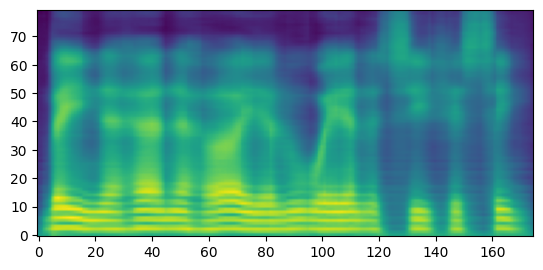

In [39]:
# fastpitch_model_path = "/kaggle/working/FastPitch--val_loss=0.7877-epoch=234-last.ckpt"  

mixer_model_path = "/kaggle/working/Mixer-TTS--val_mel_loss0.7356-epoch57.ckpt"
hfg_path_gt = "/kaggle/working/HifiGan--val_loss=0.4375-epoch=9.ckpt"
vocoder_model_pt_gt = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path_gt).eval().cuda() 

# spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval()#.cuda()

spec_gen = MixerTTSModel.load_from_checkpoint(checkpoint_path=mixer_model_path).eval().cuda()

if isinstance(spec_gen, FastPitchModel):
    tokens = spec_gen.parse(str_input="Hey, this produces speech!")
else:
    tokens = spec_gen.parse(text="b a y n a h aa n a h r aa y a l uu0 w a y aa n g t s ii0 sil f ii0 SS II0 n")

spectrogram = spec_gen.generate_spectrogram(tokens=tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the Inference_ModelSelect notebook on how to convert spectrograms to speech.
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

In [40]:
import json
data = []
with open('/kaggle/working/train_data_mbzuai.json', 'r', encoding='utf-8') as f:
    for line in f:
            # Parse each line as a JSON object
            try:
                entry = json.loads(line.strip())  # Use strip to remove any extra whitespace/newlines
                data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                
data[2]

{'audio_filepath': '/kaggle/working/MBZUAI_ClArTTS_cleaned/ch_20_arabic_tts_dataset_20.flac',
 'text': 'q A l ii0 l a t a n b a y n a l m u0 k ^ i0 r ii0 n a f a < i0 nn a nn aa s a',
 'duration': 2.833}

In [41]:
seed = 20
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, text):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(text=text, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

torch.Size([1, 80, 168])


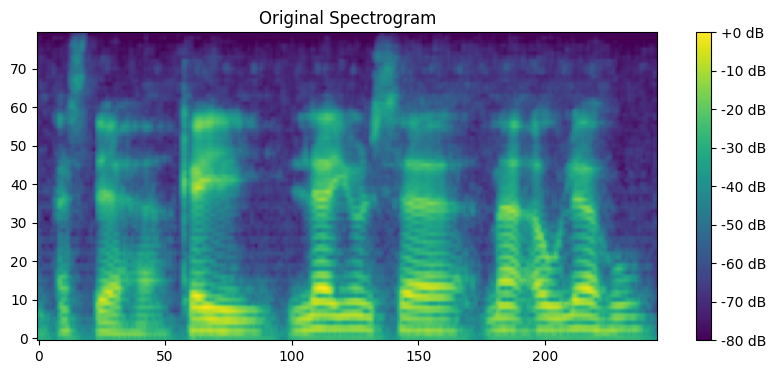

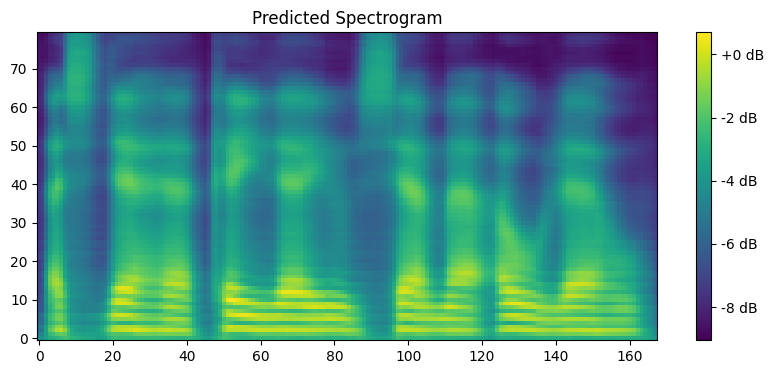

Original audio:


Predicted audio:


text:  < a s d aa h aa k a y l aa y u0 n s aa m aa < a w l aa h u0

audio_filepath:  /kaggle/working/MBZUAI_ClArTTS_cleaned/ch_11_arabic_tts_dataset_177.flac


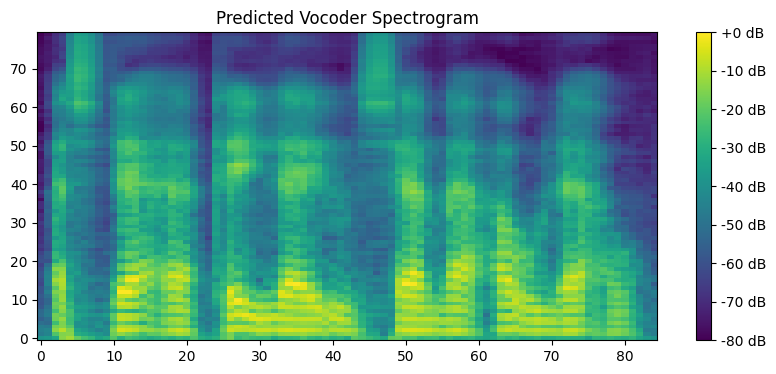

In [47]:
%matplotlib inline

index = 567 #88
t_or_tst = 'train'
# t_or_tst = 'test'
# audio_filepath = nawar_dataset[t_or_tst][index]['file']
# text = nawar_dataset[t_or_tst][index]['phonetic']
# text = re.sub(r"[0-9']", "", text)
text = data[index]["text"]
audio_filepath = data[index]["audio_filepath"]
# audio_filepath = "/kaggle/working/nawar_cleaned_dataset/" + audio_filepath.replace(".wav", ".flac")
# text = "r U0 S b a r a sil w a t a r U0 SS A r a sil w a t u0 r U0 S A r u1 n sil w a s a rr u1 n sil t A S A rr u0 r u0"
# text = "b i0 s m i0 ll a h i0 rr a H m a n i0 rr a H ii0 m i0"
# text = "l H a m d u0 l i0 ll a h i0 r a bb i0 l E a l a m ii0 n a"
# text = "a rr a H m a n i0 rr a H ii0 m i0 m a l i0 k i0 y a uu0 m i0 dd ii0 n i0 < ii0"
# text = "< ii0 y aa k a n a E b u0 d u0 w a < ii0 y aa k a n a s t a E ii0 n u0"
# text = "i0 h d i0 n aa SS I0 r a T A l m u0 s t A q II0 m a "
# text = "S I0 r a T A ll a * ii0 n a < a n E a m t a E a l a ii0 h i0 m g A ii0 r i0 l m a g D UU0 b i0 E a l a ii0 h i0 m w a l aa DD AA ll ii0 n a"


# Function to compute mel spectrogram
def compute_mel_spectrogram(audio, sr=22050):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

# Load original audio and compute spectrogram
original_audio, sr = librosa.load(audio_filepath, sr=22050)
original_spectrogram = compute_mel_spectrogram(original_audio, sr)


audio , predicted_spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen, vocoder_model_pt_gt, text)

# Plot original spectrogram
plt.figure(figsize=(10, 4))
# librosa.display.specshow(original_spectrogram, sr=sr, hop_length=256, x_axis="time", y_axis="mel")
plt.imshow(original_spectrogram, aspect="auto", origin="lower", cmap="viridis")
plt.title("Original Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

# Plot predicted spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(predicted_spectrogram, origin="lower", aspect="auto", cmap="viridis")
plt.title("Predicted Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

# Display original and predicted audio
print("Original audio:")
ipd.display(ipd.Audio(audio_filepath, rate=sr))

print("Predicted audio:")
ipd.display(ipd.Audio(audio, rate=22050))

print("text: ", text)
print("\naudio_filepath: ", audio_filepath)

mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db, origin="lower", aspect="auto", cmap="viridis")
plt.title("Predicted Vocoder Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

# # Measure the difference
# mse = mean_squared_error(original_spectrogram.flatten(), predicted_spectrogram.flatten())
# print(f"Mean Squared Error between spectrograms: {mse}")